In [309]:
# # Installing Packages
# options(repos = c(CRAN="https://cloud.r-project.org"))
# install.packages(c('‘hwwntest'))

In [1]:
library(dynlm)
library(car)
library(carData)
library(zoo)
library(xts)
library(tsbox)
library(tseries)
library(forecast)
library(astsa)
library(gvlma)
library(hwwntest)

Warning message:
"package 'dynlm' was built under R version 3.5.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.5.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'car' was built under R version 3.5.3"Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.5.3"Warning message:
"package 'xts' was built under R version 3.5.3"Warning message:
"package 'tsbox' was built under R version 3.5.3"Warning message:
"package 'tseries' was built under R version 3.5.3"Warning message:
"package 'forecast' was built under R version 3.5.3"Warning message:
"package 'astsa' was built under R version 3.5.3"
Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas

Warning message:
"package 'gvlma' was built under R version 3.5.2"Warning message:
"package 'hwwntest' was built under R version 3.5.3

In [2]:
# Making an xts object for the data
# Mumbai

mumbai <- as.data.frame(read.csv("../../Data/DistTimeSeries/Cases/Mumbai.csv", sep = ","))
mumbai$ï..Date <- as.Date(mumbai$ï..Date , format = "%d-%m-%Y")
colnames(mumbai) <- c("Date", "NewCases", "TotalCases", "Lockdown", "Temperature", "RH")
mumbai.xts <- xts(mumbai, order.by=mumbai$Date)
mumbai.xts <- mumbai.xts[, colnames(mumbai.xts) != "Date"]
tail(mumbai)

,Date,NewCases,TotalCases,Lockdown,Temperature,RH
84,2020-04-22,232,3683,1,35,65
85,2020-04-23,522,4205,1,35,68
86,2020-04-24,242,4447,1,36,70
87,2020-04-25,602,5049,1,37,63
88,2020-04-26,358,5407,1,35,64
89,2020-04-27,371,5778,1,34,69


In [19]:
# We make date with zero cases to 1 case
mumbai.xts$NewCases <- replace(mumbai.xts$NewCases, (as.numeric(mumbai.xts$NewCases) == 0), "1")

# Making new dataset after 20-Mar
startDate <- as.Date("25-Mar-20" , format = "%d-%b-%y")
endDate <- as.Date("27-Apr-20" , format = "%d-%b-%y")

newMumbai.xts <- subset(mumbai.xts, index(mumbai.xts)>=startDate)
newMumbai.xts <- subset(newMumbai.xts, index(newMumbai.xts)<=endDate)
# mumbai.xts$NewCases

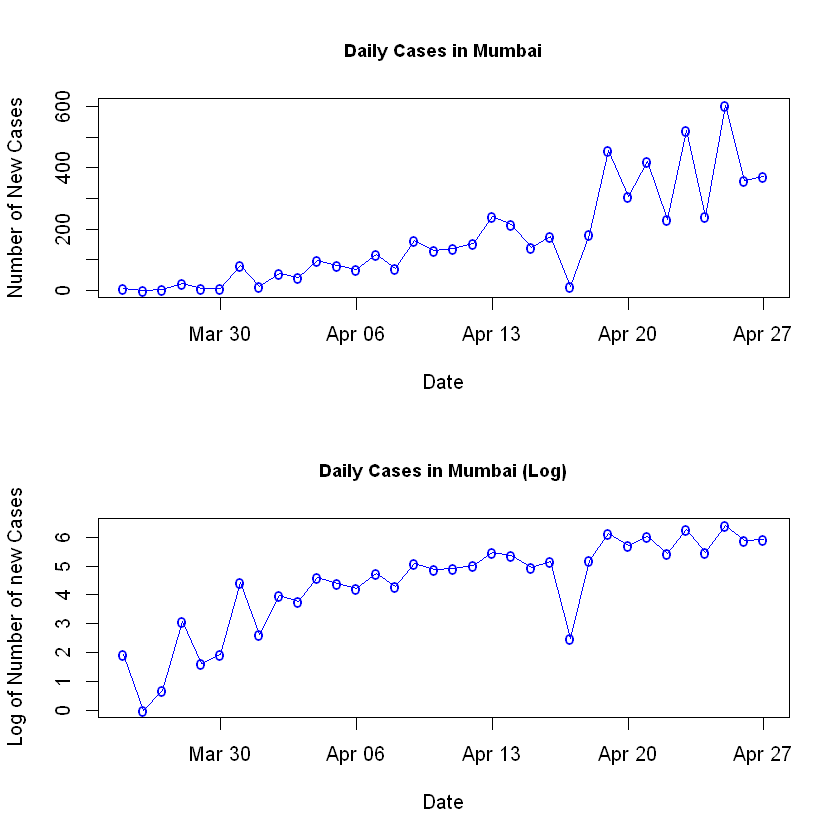

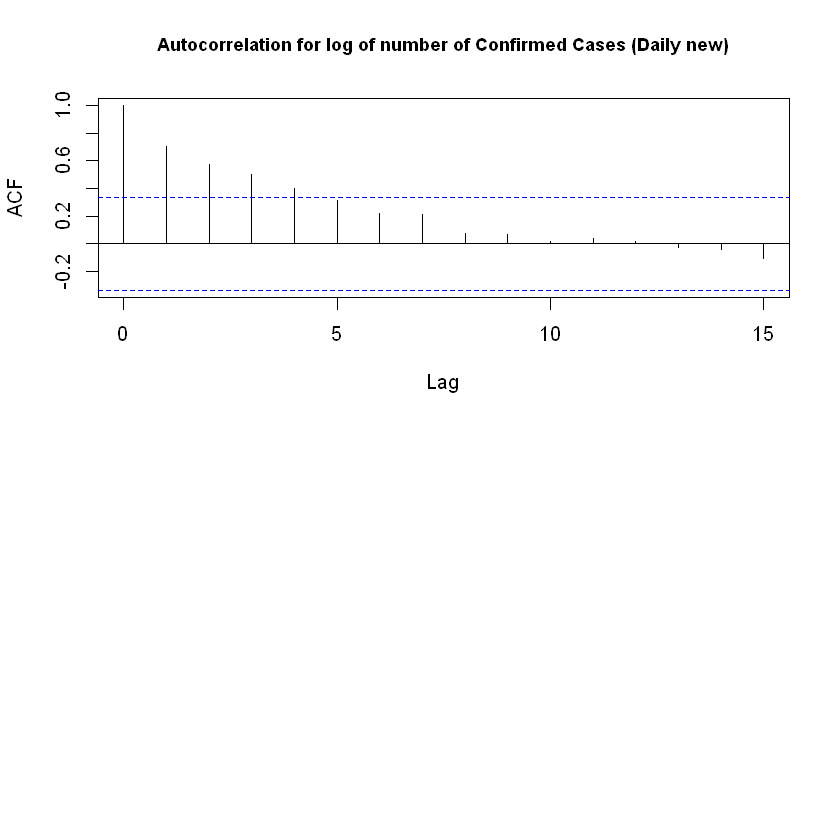

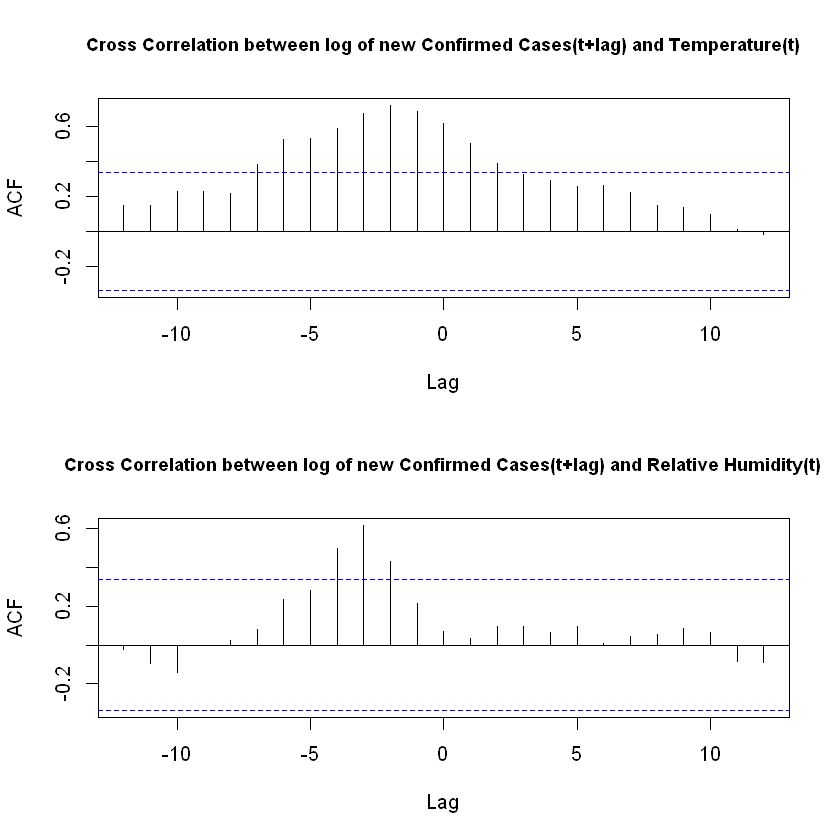

In [20]:
# Plots for Daily new Cases

par(mfrow = c(2,1), cex.main=0.9) # set up the graphics
plot(index(newMumbai.xts), newMumbai.xts$NewCases, type="o", col="blue", pch="o", lty=1, main="Daily Cases in Mumbai", ylab="Number of New Cases", xlab="Date")
plot(index(newMumbai.xts), log(as.numeric(newMumbai.xts$NewCases)), type="o", col="blue", pch="o", lty=1, main="Daily Cases in Mumbai (Log)", ylab="Log of Number of new Cases", xlab="Date")

par(mfrow = c(2,1))
acf(log(as.numeric(newMumbai.xts$NewCases)), main="Autocorrelation for log of number of Confirmed Cases (Daily new)")
# ccf(log(as.numeric(newMumbai.xts$NewCases)), as.numeric(newMumbai.xts$Lockdown), main="Cross Correlation between log of new Confirmed Cases(t+lag) and Lockdown(t)")

par(mfrow = c(2,1), cex.main=0.9)
ccf(log(as.numeric(newMumbai.xts$NewCases)), as.numeric(newMumbai.xts$Temperature), main="Cross Correlation between log of new Confirmed Cases(t+lag) and Temperature(t)")
ccf(log(as.numeric(newMumbai.xts$NewCases)), as.numeric(newMumbai.xts$RH), main="Cross Correlation between log of new Confirmed Cases(t+lag) and Relative Humidity(t)")


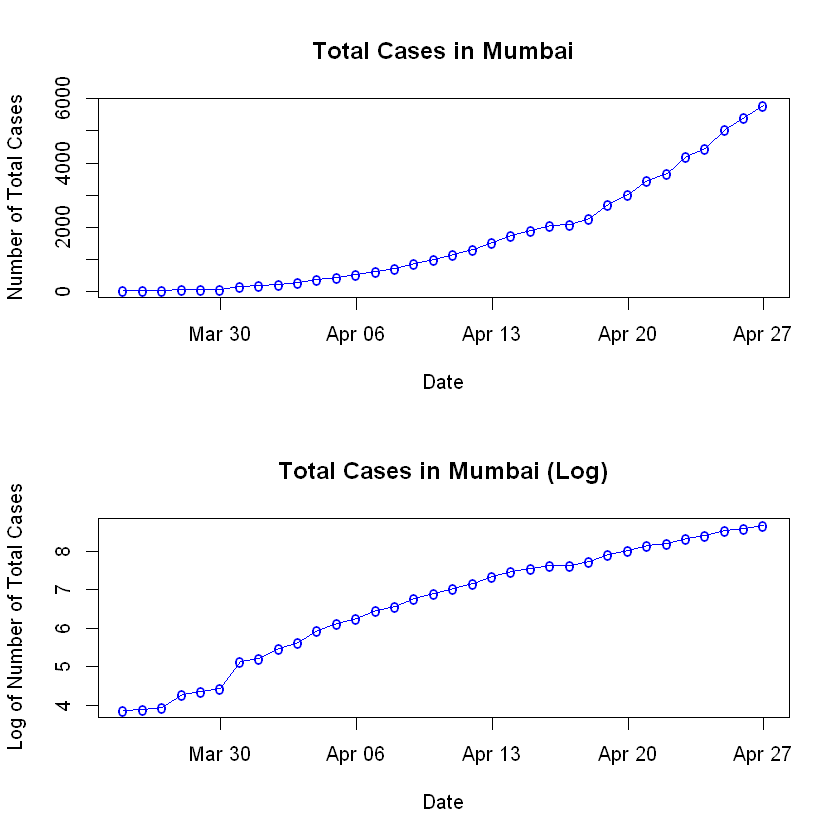

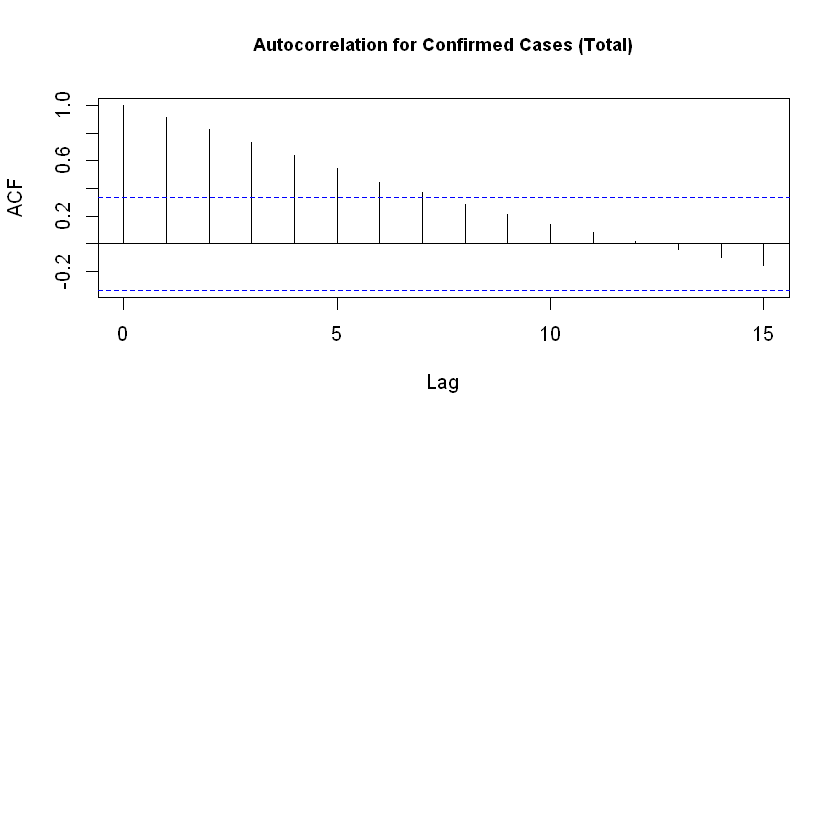

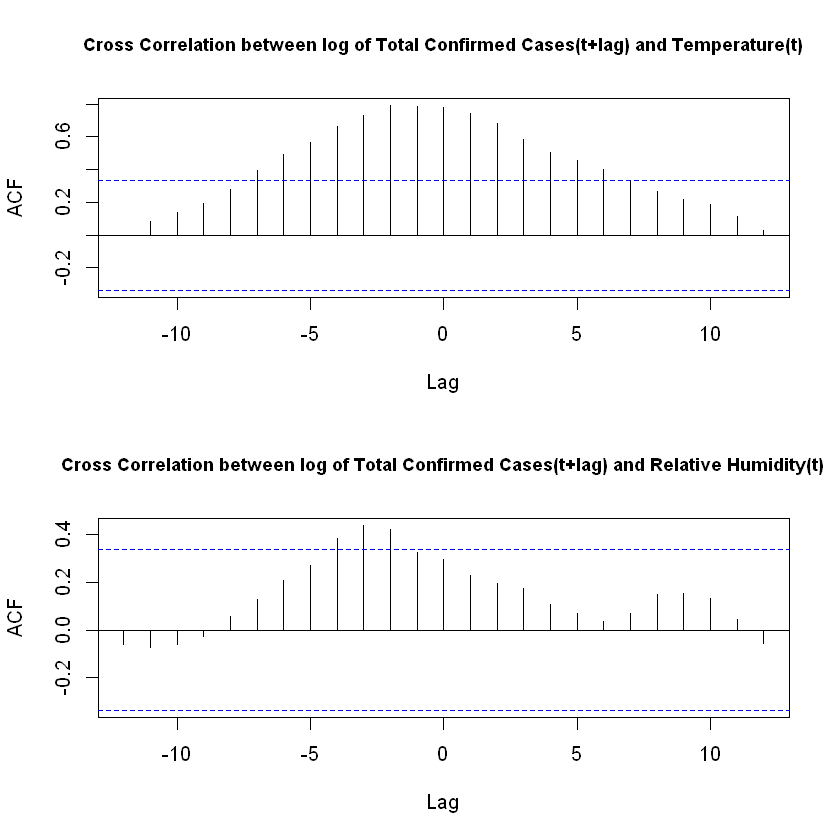

In [21]:
# Plots for Total Cases

par(mfrow = c(2,1)) # set up the graphics
plot(index(newMumbai.xts), newMumbai.xts$TotalCases, type="o", col="blue", pch="o", lty=1, main="Total Cases in Mumbai", ylab="Number of Total Cases", xlab="Date")
plot(index(newMumbai.xts), log(as.numeric(newMumbai.xts$TotalCases)), type="o", col="blue", pch="o", lty=1, main="Total Cases in Mumbai (Log)", ylab="Log of Number of Total Cases", xlab="Date")

par(mfrow = c(2,1), cex.main=0.9)
acf(log(as.numeric(newMumbai.xts$TotalCases)), main="Autocorrelation for Confirmed Cases (Total)")
# ccf(log(as.numeric(newMumbai.xts$TotalCases)), as.numeric(newMumbai.xts$Lockdown), main="Cross Correlation between log of Total Confirmed Cases(t+lag) and Lockdown(t)")

par(mfrow = c(2,1), cex.main=0.9)
ccf(log(as.numeric(newMumbai.xts$TotalCases)), as.numeric(newMumbai.xts$Temperature), cex=0.25, main="Cross Correlation between log of Total Confirmed Cases(t+lag) and Temperature(t)")
ccf(log(as.numeric(newMumbai.xts$TotalCases)), as.numeric(newMumbai.xts$RH), main="Cross Correlation between log of Total Confirmed Cases(t+lag) and Relative Humidity(t)")

In [22]:
# Making time squared trend to be fit
# Adding plus 1 kyunki baadme vo subtract ho jaayega
timeTrend_2 <- (1:length(index(newMumbai.xts)))^2  
timeTrend <- (1:length(index(newMumbai.xts)))

mumbai.reg.data <- data.frame(log(as.numeric(coredata(newMumbai.xts$NewCases))),
                              as.numeric(coredata(newMumbai.xts$Temperature)), as.numeric(coredata(newMumbai.xts$RH)),   
                              timeTrend, timeTrend_2)
colnames(mumbai.reg.data) <- c("TimeSeries", "Temperature", "RH", "timeTrend", "timeTrend_2")

# mumbai.reg.data.matrix <- data.matrix(mumbai.reg.data)
# mumbai.reg.data.xts <- xts(mumbai.reg.data, order.by=index(newMumbai.xts))
mumbai.reg.data.ts <- as.ts(mumbai.reg.data, order.by=index(newMumbai.xts))
# index(mumbai.reg.data.zoo)
# mumbai.reg.data.ts 

## Let's de trend the total Cases Data

In [23]:
mumbai.reg.data.ts['Temperature']

[1] NA


Time series regression with "ts" data:
Start = 2, End = 34

Call:
dynlm(formula = TimeSeries ~ timeTrend + timeTrend_2 + L(Temperature, 
    1) + L(RH, 1), data = mumbai.reg.data.ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.28110 -0.30932 -0.00946  0.37909  1.36885 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        9.119262   2.963599   3.077 0.004638 ** 
timeTrend          0.409569   0.064407   6.359    7e-07 ***
timeTrend_2       -0.006371   0.001619  -3.936 0.000499 ***
L(Temperature, 1) -0.220188   0.102971  -2.138 0.041355 *  
L(RH, 1)          -0.031548   0.025477  -1.238 0.225887    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.748 on 28 degrees of freedom
Multiple R-squared:  0.8109,	Adjusted R-squared:  0.7839 
F-statistic: 30.02 on 4 and 28 DF,  p-value: 9.231e-10


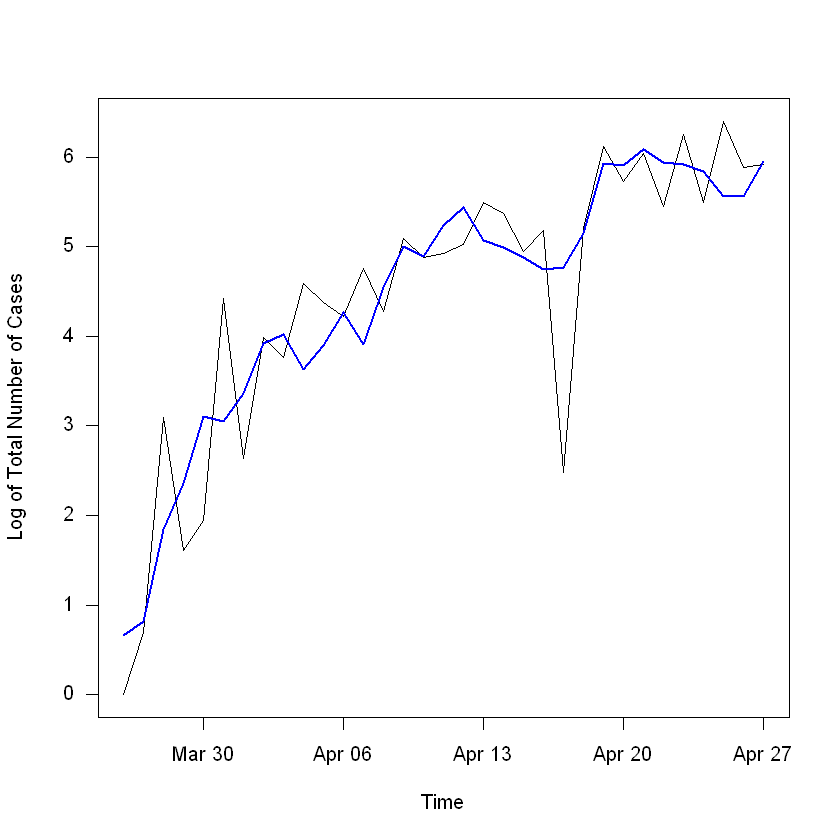

In [24]:
dataTimeSeries <- log(as.numeric(newMumbai.xts$NewCases))
numRows <- length(dataTimeSeries)
start = 2
detrended <- dynlm(TimeSeries ~ timeTrend+timeTrend_2+L(Temperature,1)+L(RH,1), data=mumbai.reg.data.ts)
summary(detrended)
prediction <- predict(detrended)
plot(index(newMumbai.xts)[start:numRows], dataTimeSeries[start:numRows], "l", las=1, xlab="Time", ylab="Log of Total Number of Cases")
lines(prediction~index(newMumbai.xts)[start:numRows], col="blue", lwd=2)
# plot(residuals(detrended))
# shapiro.test(detrended$residuals)

In [25]:
prediction[31]

a <- 3.2911535+0.2775374*33-0.0035953*1089-0.0042868*37+0.0009491*63
a

32 
5.566154

[1] 8.435788

In [26]:
# Forecasting
# Predicting for 26th, 27th and 28th
time <- c(35)
timeSquared <- time*time

# For 25th, 26th and 27th
temperature <- c(33)
RelHum <- c(70)
data <- data.frame(temperature, RelHum, time, timeSquared)
colnames(data) <- c("Temperature", "RH", "timeTrend", "timeTrend_2")
data
pred <- predict(detrended, newdata = data)
varianceError <- var(detrended$residuals)
varianceError <- varianceError/2
varianceError
pred <- pred+varianceError
pred
finalPred <- exp(pred)
finalPred
initial <- exp(dataTimeSeries[32])
initial

Temperature,RH,timeTrend,timeTrend_2
33,70,35,1225


[1] 0.2447925

1 
6.41959

1 
613.7517

[1] 602

In [27]:
# Test for white noise
bartlettB.test(detrended$residuals)


	Bartlett B Test for white noise

data:  
= 0.92405, p-value = 0.3604


## ------------------------------------------------------------------------------------------------------------------------

### We see that there is ccf between y and error, let's make an ARIMA model now

In [124]:
nrows <- length(detrended$residuals)
residualTimeSeries <- detrended$residuals
fit <- auto.arima(residualTimeSeries, method="ML")
fit

Series: residualTimeSeries 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.5421:  log likelihood=-41.17
AIC=84.35   AICc=84.46   BIC=85.96

In [117]:
# For autocorrelation in residuals
durbinWatsonTest(detrended, max.lag=3)


 lag Autocorrelation D-W Statistic p-value
   1     -0.20646156      2.383381   0.654
   2      0.01358491      1.913678   0.536
   3      0.25778924      1.402050   0.086
 Alternative hypothesis: rho[lag] != 0

In [84]:
# Making two beta waala model using auto-ARIMA and new datasets
nrows <- length(mumbai.reg.data$timeTrend)
print(nrows)

# Making a data with 6 columns, we can change entries according to the date
# Format-> Lockdown|Lockdown_7|Lockdown_10|time_trend_1|squared_time_trend_1|time_trend_2|squared_time_trend_2

modMumbaireg.data <- cbind(mumbai.reg.data,time_trend_2=mumbai.reg.data$timeTrend,
                            squared_time_trend_2=mumbai.reg.data$timeTrend_2)
colnames(modMumbaireg.data)<- c("Lockdown_4", "Lockdown_5", "Temp_0", "Temp_1", "Temp_2", "RH_11", "time_trend_1", "squared_time_trend_1", 
                           "time_trend_2", "squared_time_trend_2")
# modGujaratreg.data

# ARIMA Initialisation

dataTimeSeries <- log(as.numeric(newMumbai.xts$NewCases))
aicLevel <- 1000
etaDate = index(newMumbai.xts)[1]
finalModel <- 0

# StartDate = 20th March
for (eta in (3:(nrows-2))){
    tempXreg.data <- modMumbaireg.data
    for (tempEta_2 in (1:(eta-1))){
        tempXreg.data[tempEta_2,"time_trend_2"] <- 1
        tempXreg.data[tempEta_2,"squared_time_trend_2"] <- 1
    }
    for (tempEta_1 in (eta:nrows)){
        tempXreg.data[tempEta_1,"time_trend_1"] <- 1
        tempXreg.data[tempEta_1,"squared_time_trend_1"] <- 1
    }
    
    tempXreg.matrix <- data.matrix(tempXreg.data)-1
    regressors <- tempXreg.matrix
    tempFit <- auto.arima(dataTimeSeries, xreg=regressors, method="ML")
    if(tempFit$aicc < aicLevel){
        aicLevel <- tempFit$aicc
        etaDate <- as.Date(startDate + eta)
        finalModel <- tempFit
    }
}
print(etaDate)
finalModel

[1] 27
[1] "2020-03-29"


Series: dataTimeSeries 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  Lockdown_4  Lockdown_5   Temp_0  Temp_1   Temp_2   RH_11
      -0.8931     -3.5542      1.8645  -0.0159  0.1720  -0.1460  0.0064
s.e.   0.0803      0.3283      0.2855   0.0371  0.0515   0.0346  0.0079
      time_trend_1  squared_time_trend_1  time_trend_2  squared_time_trend_2
            0.7502               -0.1052        0.4612               -0.0088
s.e.        0.1129                0.0119        0.0332                0.0009

sigma^2 estimated as 0.06402:  log likelihood=5.06
AIC=13.88   AICc=36.17   BIC=29.43

[1] 28 29

Time Series:
Start = 28 
End = 29 
Frequency = 1 
[1] 264.5845 137.7562

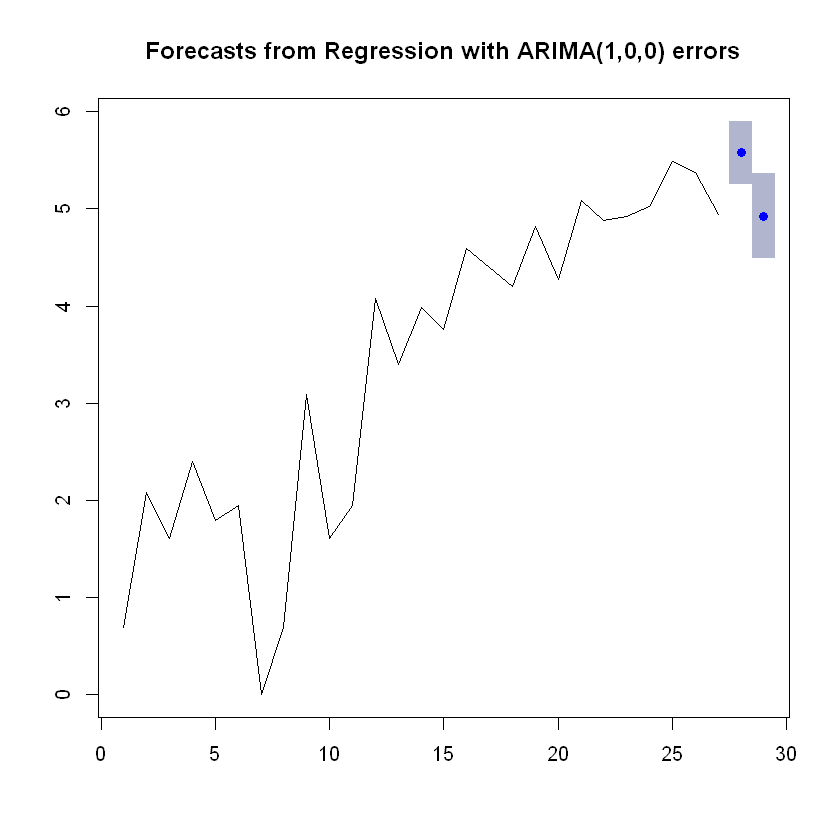

In [86]:
# Forecasting the above model for two days
# Setting the lockdown variable for future
lastDate <- index(newMumbai.xts)[nrows]
lock <- sample(1:1, 2, replace = TRUE)
time_Before <- c(0,0)
time <- (as.numeric(lastDate-startDate+2):(as.numeric(lastDate-startDate)+3))
time
time_2 <- time * time
temp_0 <- c(38,35)
temp_1 <- c(38,38)
temp_2 <- c(37,38)
RH_11 <- c(65,70)
regressor.data <- data.frame(lock,lock,temp_0,temp_1,temp_2,RH_11,time_Before,time_Before,time,time_2)
colnames(regressor.data)<- c("Lockdown_4", "Lockdown_5", "Temp_0", "Temp_1", "Temp_2", "RH_11", "time_trend_1", "squared_time_trend_1", 
                           "time_trend_2", "squared_time_trend_2")
regressor.matrix <- data.matrix(regressor.data)

# Forecast
fore <- forecast(finalModel, level=80,  xreg=regressor.matrix)
plot(fore)
# (fore$mean)
exp((fore$mean))